# LibraryThings Recommendation System

## 1. Loading reviews.txt

In [1]:
#importing the librarys
import numpy as np
import pandas as pd

In [2]:
import ast

In [4]:
# read the files
review_list = []
with open('reviews.txt', 'r') as f:
    for line in f:
        if line == 'reviews = {}\n':
            continue
        try:
            _, review = line.split(')] = ')
            review_list.append(ast.literal_eval(review))
        except:
            print(line)
            break

In [4]:
# review_list

Pickling for future use to avoid preprocessing the data again.

In [12]:
# converting it to dataframe
reviews_df = pd.DataFrame(review_list)

## 2. Understanding the data

Looking at the data, we have the following columns:
* comment: User review/comments about the book
* nhelpful: Number of users who found the review/comment helpful
* unixtime: UNIX time when review/comment was submitted
* work: Book identifier
* flags: Can be from the following values: \['', 'not_a_review', 'abuse'\]
* user: Username
* stars: Ratings on a scale of 5
* time: Date when review was submitted

Based on the following, it seems that *unixtime* and *time* represent the same, and are therefore redundant.

In [7]:
# calculating the number of missing values
reviews_df.isna().sum()

comment          0
nhelpful         0
unixtime        90
work             0
flags            0
user             0
stars       319861
time            90
dtype: int64

In [8]:
# dropping the missing values
reviews_df.dropna(inplace=True)

In [9]:
reviews_df.isna().sum()

comment     0
nhelpful    0
unixtime    0
work        0
flags       0
user        0
stars       0
time        0
dtype: int64

### Unpacking flags list

Since *flags* contains lists which are unhashable, we cannot identify duplicate rows. We need to convert *flags* into a separate feature.

In [10]:
# converting the date column to flags
reviews_df['flags'].apply(lambda x: tuple(_ for _ in x) if x else ()).unique()

array([(), ('not_a_review',), ('abuse',), ('abuse', 'not_a_review')],
      dtype=object)

In [11]:
# converting the flags column to  abuse column
reviews_df['abuse'] = reviews_df['flags'].apply(lambda x: 'abuse' in x)

In [12]:
# converting the flags column to not a review column
reviews_df['not_a_review'] = reviews_df['flags'].apply(lambda x: 'not_a_review' in x)

In [13]:
# dropping the flags column
reviews_df.drop('flags', axis = 1, inplace=True)

In [14]:
# printing the dataframe with not a review column
reviews_df[reviews_df['not_a_review']]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
55,"A disturbing book, but one that I can recommend.",0,1.169251e+09,1199218,writestuff,4.0,"Jan 20, 2007",False,True
193,"USA, ca 1984.\nHovedpersonen William Halleck k...",0,1.226794e+09,35834,bnielsen,4.0,"Nov 16, 2008",False,True
434,I loved this book -- Corey Sifter is a likeabl...,0,1.237507e+09,69759,stephaniechase,3.0,"Mar 20, 2009",False,True
639,http://en.wikipedia.org/wiki/The_Glenn_Miller_...,0,1.282435e+09,11528316,wdjoyner,4.0,"Aug 22, 2010",True,True
689,Listen/read my review here - http://alchemyofs...,0,1.311206e+09,11010126,nownewstrue,4.0,"Jul 21, 2011",False,True
...,...,...,...,...,...,...,...,...,...
1706781,"CWE founded 1881, pub 1st ed 1885, see entry, ...",0,1.269475e+09,9734301,kitchengardenbooks,4.0,"Mar 25, 2010",False,True
1706856,I included this book in my book: The 100 Best ...,0,1.241741e+09,7605,toddsattersten,5.0,"May 8, 2009",True,True
1706889,http://bookchronicle.wordpress.com/2007/10/19/...,0,1.223338e+09,1488,bookchronicle,4.0,"Oct 7, 2008",False,True
1707030,Setting: United StatesReview? Maybe later or m...,0,1.282522e+09,522063,thereshegoes,4.0,"Aug 23, 2010",False,True


Let's look at a few 'not_a_review' flagged entries

LibraryThings says the following about the flags system:

`Important: Do not abuse this feature. "Not a review" is not intended for short reviews, poorly-written reviews or reviews you disagree with. Links to the reviewer's blog are also acceptable. "Abuse of terms of service" includes violations such as spam reviews and posting copyrighted material without permission. See the terms of service for more guidelines.`


Users can flag reviews as "Not a review" or "Abuse of terms of service". What I have gathered from discussions on https://www.librarything.com/ngroups/2862/Flaggers%21 is that reviews where people do not provide anything meaningful about the book, and simple pass comments are likely to be flagged as "Not a review". But this isn't always the case, as people get wrongly flagged. The website uses an appeal/counter-flag system. Abuse includes copy-pasting reviews from other sources.

Out of the three listed above, only the second one doesn't look like a review. Looking at a few more cases, the following are definitely not reviews.

With these entries being only a little over 1%, we can drop them safely. It is true that we might lose some legit review in the process.

In [21]:
19750/reviews_df.shape[0]

0.014238082364603047

In [22]:
# printing the dataframe abuse column 
reviews_df[reviews_df['abuse']]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
143,Children's Literature - Lois Rubin Gross \nAn ...,0,1.316045e+09,8176470,EBurggraf,4.0,"Sep 15, 2011",True,False
633,Reviewed by Marta Morrison for TeensReadToo.co...,0,1.302394e+09,10886889,GeniusJen,5.0,"Apr 10, 2011",True,False
639,http://en.wikipedia.org/wiki/The_Glenn_Miller_...,0,1.282435e+09,11528316,wdjoyner,4.0,"Aug 22, 2010",True,True
1132,The only up-to-date anthology of traditional A...,0,1.196381e+09,3340171,butterfly3,4.0,"Nov 30, 2007",True,False
1147,"I decided to read this book, because the topic...",0,1.307664e+09,7997468,Princetonbookreview,4.0,"Jun 10, 2011",True,False
...,...,...,...,...,...,...,...,...,...
1703962,"Reviewer:\tG. Merritt (Boulder, CO) - See all ...",0,1.138752e+09,32389,gnewfry,5.0,"Feb 1, 2006",True,False
1704292,Reviewed by Jaglvr for TeensReadToo.com\n1989 ...,0,1.292026e+09,9900705,GeniusJen,5.0,"Dec 11, 2010",True,False
1704347,Wikipedia: The Rise and Fall of the Third Reic...,0,1.159402e+09,3038,billyfantles,5.0,"Sep 28, 2006",True,True
1704374,Reviewed by Carrie Spellman for TeensReadToo.c...,0,1.255392e+09,3576179,GeniusJen,5.0,"Oct 13, 2009",True,False


In [23]:
reviews_df.loc[1147].comment

'I decided to read this book, because the topic is unusual and I was intrigued by the Renaissance era. The backdrop for this book is a convent in the late 1500s. This is excellent well-researched Historical Fiction with great insight into convent life during this time period. Its fascinating and disturbing to realize that at one time women were forced into the convent because their families had only enough money for one dowry or they were disfigured or simply not pretty enough. In this story, Serafina enters the convent against her will because she refuses to marry the man he father chooses for her. Shes young, rebellious and determined to escape, which adds a layer of mystery to the story as you wonder if she will succeed. On a deeper level this book explores the hierarchy of female leadership in a closed all female society.\nReview previously posted at: www.princetonbookreview.com\nFind us on Face book http://www.facebook.com/#%21/pages/Princeton-Book-Review/73532562757 '

The above review abuses the TOS of LibraryThings. While the review provides us the details about the book, it doesn't convey the user's thoughts.

In [24]:
# dropping the all the values with true values in abuse column
review_df = reviews_df[reviews_df.abuse != True]

In [25]:
# dropping the all the values with true values in not a review column
review_df = reviews_df[reviews_df.not_a_review != True]

In [26]:
review_df

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
0,"Every evening, the brave queen of Persia, Shah...",0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"Mar 21, 2012",False,False
1,Its the 1983-84 school year and Edward Zanni o...,0,1.253405e+09,69413,rivkat,3.0,"Sep 20, 2009",False,False
2,"I became privy to this book, when another auth...",0,1.299888e+09,9523995,suz.haugland,4.0,"Mar 12, 2011",False,False
3,.,0,1.327277e+09,368228,amoskovacs,4.0,"Jan 23, 2012",False,False
4,This is a tremendous story of a freed woman an...,0,1.329005e+09,11243828,CandyH,4.0,"Feb 12, 2012",False,False
...,...,...,...,...,...,...,...,...,...
1707063,http://olvasonaplo.freeblog.hu/archives/2007/0...,0,1.209082e+09,76280,sorsha,3.0,"Apr 25, 2008",False,False
1707064,I came to this book with low expectations. The...,0,1.314230e+09,11633344,TheLogo,4.5,"Aug 25, 2011",False,False
1707066,This is a fairy tale which is very much a Cupi...,0,1.364688e+09,11749693,AmyMacEvilly,5.0,"Mar 31, 2013",False,False
1707067,http://tamaranth.blogspot.com/1994/03/guilty-p...,0,1.176682e+09,4873693,tamaranth,4.5,"Apr 16, 2007",False,False


### 2.1 Duplicate samples

In [29]:
# dropping the duplicates values
review_df[review_df.duplicated()]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review


It seems that there are no duplictes.

### 2.3 stars
We see that all ratings are between 0 and 5, with increments of 0.5.

In [30]:
# finding the unique ratings of books
review_df['stars'].unique()

array([4.5, 3. , 4. , 2. , 3.5, 5. , 1. , 2.5, 0.5, 1.5])

### 2.4 nhelpful

In [31]:
review_df['nhelpful'].unique()

array([  0,   6,   2,   1,   5,   7,   3,   4,  16,  22,  12,  18,  11,
        21,  13,  10,   9,   8,  47,  20,  30,  33,  15,  19,  28,  37,
        31,  23,  14,  26,  17,  36,  25,  72,  52,  27,  34,  58,  48,
        24,  63,  79,  32,  38, 129,  75,  29,  46, 332, 108,  40,  87,
        39,  68, 189,  59, 152, 100,  66,  44,  82,  41,  78,  45,  60,
        43, 316,  49,  76,  70,  77,  55,  67,  74])

In [32]:
review_df['nhelpful'].value_counts()

0     1203898
1      117058
2       25988
3        9051
4        3947
       ...   
63          1
52          1
72          1
47          1
74          1
Name: nhelpful, Length: 74, dtype: int64

In [33]:
type(review_df['nhelpful'].value_counts())

pandas.core.series.Series

In [34]:
from matplotlib import pyplot as plt 

<Axes: >

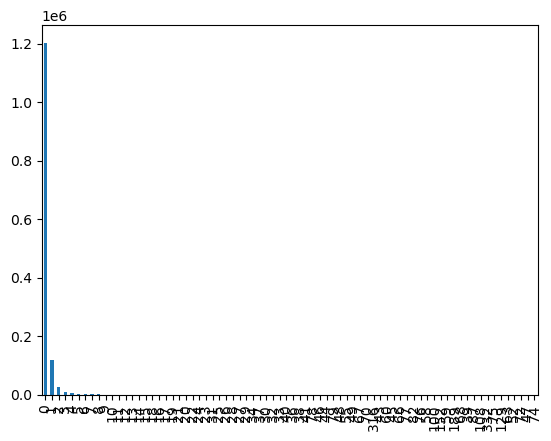

In [35]:
review_df['nhelpful'].value_counts().plot(kind='bar')

This is expected as most books are not a popular. People may therefore never read the reviews for these books and hence never find the reviews helpful.

### 2.5 comment

We see that there are a few comments with URLs. We need to clean these to ensure proper embeddings.

In [36]:
# finding the not need reviews
review_df[review_df['comment'].str.contains('http|www')]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
11,Monitor life.\nhttp://freesf.strandedinoz.com/...,0,1.309910e+09,11162023,BlueTysonSS,3.5,"Jul 6, 2011",False,False
12,You enter the moment of the naked lunch when y...,6,1.286150e+09,5852,funkendub,5.0,"Oct 4, 2010",False,False
14,"In these days of Echelon, Satellite spying, an...",1,1.169856e+09,1472,bluetyson,5.0,"Jan 27, 2007",False,False
29,C'est pour moi une premire exprience avec l'au...,0,1.365034e+09,8311485,Moncoinlecture,3.0,"Apr 4, 2013",False,False
61,Review posted here: http://offbeatvagabond.blo...,1,1.336090e+09,11357432,harleyquinn0887,5.0,"May 4, 2012",False,False
...,...,...,...,...,...,...,...,...,...
1706975,http://boekenwijs.blogspot.com/2008/05/heart-o...,0,1.210464e+09,2575,boekenwijs,2.0,"May 11, 2008",False,False
1706999,http://nwhyte.livejournal.com/1700514.html\nHe...,0,1.302307e+09,1411914,nwhyte,3.5,"Apr 9, 2011",False,False
1707039,http://library.tom-hanna.org/2007/margaret-lob...,0,1.189037e+09,35552,tomhanna,4.0,"Sep 6, 2007",False,False
1707063,http://olvasonaplo.freeblog.hu/archives/2007/0...,0,1.209082e+09,76280,sorsha,3.0,"Apr 25, 2008",False,False


In [37]:
# Percentage reviews with containing 'http' or 'www'

83774/review_df.shape[0]

0.061266294908126885

In [38]:
# URL not guaranteed to contain with 'http'.
review_df[review_df['comment'].str.contains(' www')]

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review
12,You enter the moment of the naked lunch when y...,6,1.286150e+09,5852,funkendub,5.0,"Oct 4, 2010",False,False
162,It's a real shame for Monica Pradhan that AMy ...,0,1.321488e+09,2411376,bookczuk,3.0,"Nov 17, 2011",False,False
451,"What is it like... to be considered: ""Genius?""...",0,1.224634e+09,5787763,ANovelMenagerie,4.0,"Oct 22, 2008",False,False
1084,I received this book through www.librarything....,0,1.323216e+09,11357953,apsing01,4.0,"Dec 7, 2011",False,False
1147,"I decided to read this book, because the topic...",0,1.307664e+09,7997468,Princetonbookreview,4.0,"Jun 10, 2011",True,False
...,...,...,...,...,...,...,...,...,...
1703742,"Nel silenzio della campagna pugliese, in un'es...",1,1.179619e+09,5950304,Streghissima,5.0,"May 20, 2007",False,False
1704179,"I bought this from Amazon at random, as I have...",0,1.360368e+09,11160219,nina.jon,4.0,"Feb 9, 2013",False,False
1705436,"In current day India, the police have called i...",0,1.301616e+09,9819803,Nickelini,4.0,"Apr 1, 2011",False,False
1705511,From the writers of the website www.gofugyours...,0,1.364688e+09,4792292,JenJ.,4.0,"Mar 31, 2013",False,False


We need to remove the URLs and use the remaining text as part of reviews. Also need to clean up any special characters, and handle escape sequences.

#### 2.5.1 Clean URLs

In [42]:
import re

In [44]:
re.sub('https?://[\S]+|www\.[\S]+', '',
       'http://tamaranth.blogspot.com/1994/03/guilty-pleasures-laurell-k-hamilton.html ')

' '

In [45]:
re.sub('https?://[\S]+|www\.[\S]+',
       '',
       """I received this book through www.librarything.com and it's early reviewer's program. I really didn't know what to expect when I received this ebook. I started the book yesterday and finished it in one day. It was very engaging. The characters were interesting and the story was fast-paced. There were parts that were thrilling, especially the beginning. The off the wall antics of Brian help lighten the story. I enjoyed traveling along with Brenda and Brian, especially the dinner with the parents scene. I wish that it had been a little longer because I'm dying to know what happens next. The ending is a bit of a cliffhanger. Yes, they solved the immediate issue with the criminal at hand but who were those other people and what do they want? I really do think that this book is a great one. The author really knows how to make people laugh at the sheer craziness of the book. \nhttp://letthemalleatcake.blogspot.com/2011/12/medium-dead-by-chris-dolley.html 

""")

"I received this book through  and it's early reviewer's program. I really didn't know what to expect when I received this ebook. I started the book yesterday and finished it in one day. It was very engaging. The characters were interesting and the story was fast-paced. There were parts that were thrilling, especially the beginning. The off the wall antics of Brian help lighten the story. I enjoyed traveling along with Brenda and Brian, especially the dinner with the parents scene. I wish that it had been a little longer because I'm dying to know what happens next. The ending is a bit of a cliffhanger. Yes, they solved the immediate issue with the criminal at hand but who were those other people and what do they want? I really do think that this book is a great one. The author really knows how to make people laugh at the sheer craziness of the book. \n \n\n"

In [46]:
# removing the URL from the comment column
reviews_df['comment']=reviews_df['comment'].str.replace('https?://[\S]+|www\.[\S]+', '', regex = True)

While we see some obvious invalid URLs due to user errors, a some are confusing. Let'slookat the below example.

It seems that the user mistakenly introduced a space between 'http://' and 'www'. We can fix these issues manually as we only have a handful of entries.

In [55]:
reviews_df['comment']=reviews_df['comment'].str.replace('https?://[\S]*|https?:/[\S]+|https?//:[\S]*|https?/:[\S]*|http:', '', regex = True)

In [56]:
# converting the reviews to lower case and droping the unnecessary spaces and special characters
reviews_df['comment']=reviews_df['comment'].str.replace("[^a-zA-Z0-9 ]",'',regex="True")
reviews_df['comment']=reviews_df['comment'].str.lower()
reviews_df['comment']=reviews_df['comment'].str.replace("\s+"," ",regex="True")

As we can see below, the remaining entries only contain http as par of the content.

#### Convert the text to embeddings

Step 1: Translate all comments to English 

Step 2: Remove stop words

In [62]:
# importing the librarys
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_set = set(stopwords.words('english'))

In [63]:
# converting the reviews to tokens and removing the stop words
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
import string
import nltk
stemmer = nltk.stem.PorterStemmer()
stop_words = set(stopwords.words('english'))
def sentencess(sentence):
    sep_char= set(string.punctuation)
    words = sentence.split()
    text= ''.join(char for char in sentence if char not in sep_char and not char.isnumeric())
    token = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.lower() not in stop_words]
    stemmed_w =[stemmer.stem(tokens)for tokens in token]
    stemmed_sentence = ' '. join(stemmed_w)
    return stemmed_sentence

In [66]:
reviews_df['new_comment']= reviews_df['comment'].apply(sentencess)

In [67]:
# saving the cleaned data to csv file
reviews_df.to_csv('cleaned_comments_2.csv')

In [ ]:
reviews_df

,comment,nhelpful,unixtime,work,user,stars,time,abuse,not_a_review,new_comment
0,every evening the brave queen of persia shahra...,0,1.332288e+09,73960,Elizabeth.Wong98,4.5,"Mar 21, 2012",False,False,everi even brave queen persia shahrazad goe su...
1,its the 198384 school year and edward zanni of...,0,1.253405e+09,69413,rivkat,3.0,"Sep 20, 2009",False,False,school year edward zanni hoboken figur get pay...
2,i became privy to this book when another autho...,0,1.299888e+09,9523995,suz.haugland,4.0,"Mar 12, 2011",False,False,becam privi book anoth author enjoy read recom...
3,,0,1.327277e+09,368228,amoskovacs,4.0,"Jan 23, 2012",False,False,
4,this is a tremendous story of a freed woman an...,0,1.329005e+09,11243828,CandyH,4.0,"Feb 12, 2012",False,False,tremend stori freed woman famili sold slaveri ...
...,...,...,...,...,...,...,...,...,...,...
1707063,,0,1.209082e+09,76280,sorsha,3.0,"Apr 25, 2008",False,False,
1707064,i came to this book with low expectations the ...,0,1.314230e+09,11633344,TheLogo,4.5,"Aug 25, 2011",False,False,came book low expect reput author drew alon en...
1707066,this is a fairy tale which is very much a cupi...,0,1.364688e+09,11749693,AmyMacEvilly,5.0,"Mar 31, 2013",False,False,fairi tale much cupid amp psychebeauti amp bea...
1707067,,0,1.176682e+09,4873693,tamaranth,4.5,"Apr 16, 2007",False,False,


In [ ]:
reviews_df['new_comment']

0          everi even brave queen persia shahrazad goe su...
1          school year edward zanni hoboken figur get pay...
2          becam privi book anoth author enjoy read recom...
3                                                           
4          tremend stori freed woman famili sold slaveri ...
                                 ...                        
1707063                                                     
1707064    came book low expect reput author drew alon en...
1707066    fairi tale much cupid amp psychebeauti amp bea...
1707067                                                     
1707069    origin met diseas cover book medic school foun...
Name: new_comment, Length: 1387125, dtype: object

## creating the embeddings from the cleaned reviews

In [77]:
# importing the librarys universal sentence encoder
import tensorflow_hub as hub
import tensorflow as tf
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


2023-04-27 14:08:02.963167: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 14:08:03.480707: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 14:08:03.483187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 14:08:04.662525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-27 14:10:00.392607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

In [78]:
def generate_embeddings(sentences):
    embeddings = embed(sentences)
    return tf.nn.l2_normalize(embeddings, axis=1)


In [79]:
embeddings = generate_embeddings(reviews_df['new_comment'])


2023-04-27 14:16:23.138179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-04-27 14:16:36.463440: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224714250000 exceeds 10% of free system memory.
2023-04-27 14:16:36.463479: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at sparse_to_dense_op.cc:120 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[1387125,6750] and type string on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
2023-04-27 14:16:36.689902: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): RESOURCE_EXHAUSTED: OOM when allocatin

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[1387125,6750] and type string on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node text_preprocessor/add_bigrams/SparseToDense}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_restored_function_body_4562]

##### Couldnot do it with univeral sentences encoder 

### creating the embedding with tf.idf vectors

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer



# Define the TF-IDF vectorizer with your custom tokens
vectorizer = TfidfVectorizer(max_features=200)

# Fit and transform the text data using the vectorizer
tfidf_matrix = vectorizer.fit_transform(reviews_df['new_comment'])


In [47]:
# Convert the embedding values to a NumPy array
embedding_array = pd.DataFrame(tfidf_matrix.toarray(),columns=vectorizer.get_feature_names_out())

# Print the resulting array
print(embedding_array)

           action    actual    almost      also  although  alway     anoth  \
0        0.000000  0.000000  0.000000  0.000000       0.0    0.0  0.228450   
1        0.000000  0.000000  0.000000  0.000000       0.0    0.0  0.000000   
2        0.080239  0.148317  0.078961  0.055431       0.0    0.0  0.137719   
3        0.000000  0.000000  0.000000  0.000000       0.0    0.0  0.000000   
4        0.000000  0.000000  0.311756  0.000000       0.0    0.0  0.000000   
...           ...       ...       ...       ...       ...    ...       ...   
1357514  0.134473  0.000000  0.000000  0.000000       0.0    0.0  0.000000   
1357515  0.000000  0.000000  0.000000  0.000000       0.0    0.0  0.000000   
1357516  0.000000  0.138319  0.000000  0.000000       0.0    0.0  0.000000   
1357517  0.143956  0.000000  0.000000  0.000000       0.0    0.0  0.000000   
1357518  0.000000  0.000000  0.000000  0.000000       0.0    0.0  0.000000   

           around    author  away  ...    wonder      word     

In [113]:

# Define the TF-IDF vectorizer with your custom tokens
vectorizer = TfidfVectorizer(max_features=200)

# Fit and transform the text data using the vectorizer
tfidf_matrix = vectorizer.fit_transform(reviews_df['user'])

In [114]:
user_array = pd.DataFrame(tfidf_matrix.toarray(),columns=vectorizer.get_feature_names_out())

# Print the resulting array
print(user_array)

         _dodds  a_reader_of_fictions  abbylibrarian  abigailadams26  adpaton  \
0           0.0                   0.0            0.0             0.0      0.0   
1           0.0                   0.0            0.0             0.0      0.0   
2           0.0                   0.0            0.0             0.0      0.0   
3           0.0                   0.0            0.0             0.0      0.0   
4           0.0                   0.0            0.0             0.0      0.0   
...         ...                   ...            ...             ...      ...   
1357514     0.0                   0.0            0.0             0.0      0.0   
1357515     0.0                   0.0            0.0             0.0      0.0   
1357516     0.0                   0.0            0.0             0.0      0.0   
1357517     0.0                   0.0            0.0             0.0      0.0   
1357518     0.0                   0.0            0.0             0.0      0.0   

         akmargie  alanpoul

In [44]:
# creating x and y values
X = reviews_df[['user', 'work']]
y = reviews_df['stars']


In [95]:
# renaming the columns
X.rename(columns={'work': 'book_id'}, inplace=True)

/tmp/ipykernel_45438/1396899955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={'work': 'book_id'}, inplace=True)


In [96]:
# adding the user and book id to the embedding array
result = pd.concat([X, embedding_array], axis=1)

In [97]:
# adding the rating to the embedding array
result = pd.concat([y, result], axis=1)

In [98]:
# dropping the null values
result=result.dropna()

In [99]:
result

,stars,user,book_id,action,actual,almost,also,although,alway,anoth,...,wonder,word,work,world,would,write,written,year,yet,young
0,4.5,Elizabeth.Wong98,73960.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.228450,...,0.115140,0.130645,0.000000,0.00000,0.086056,0.000000,0.000000,0.000000,0.0,0.000000
1,3.0,rivkat,69413.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.219776,0.0,0.000000
2,4.0,suz.haugland,9523995.0,0.080239,0.148317,0.078961,0.055431,0.0,0.0,0.137719,...,0.000000,0.000000,0.058746,0.06176,0.155634,0.000000,0.000000,0.122364,0.0,0.000000
4,4.0,CandyH,11243828.0,0.000000,0.000000,0.311756,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.262640,0.000000,0.0,0.000000
5,2.0,miyurose,9071901.0,0.000000,0.000000,0.119460,0.000000,0.0,0.0,0.000000,...,0.000000,0.119153,0.000000,0.00000,0.078486,0.091925,0.000000,0.000000,0.0,0.105193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357513,4.0,DVKov,12914798.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1357515,4.0,kaylab,7069697.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.158064,0.00000,0.139583,0.000000,0.000000,0.164617,0.0,0.000000
1357516,3.5,rlee09,4797471.0,0.000000,0.138319,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.293796,0.000000,0.00000,0.000000,0.000000,0.124074,0.000000,0.0,0.000000
1357517,5.0,melonbrawl,10621489.0,0.143956,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [120]:
# getting the x and y values
y = result['stars']

In [121]:
result = result.drop('stars', axis=1)

In [138]:
result['user'] = result['user'].astype('category')

In [139]:
result

,user,book_id,action,actual,almost,also,although,alway,anoth,around,...,wonder,word,work,world,would,write,written,year,yet,young
0,Elizabeth.Wong98,73960.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.228450,0.000000,...,0.115140,0.130645,0.000000,0.00000,0.086056,0.000000,0.000000,0.000000,0.0,0.000000
1,rivkat,69413.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.219776,0.0,0.000000
2,suz.haugland,9523995.0,0.080239,0.148317,0.078961,0.055431,0.0,0.0,0.137719,0.000000,...,0.000000,0.000000,0.058746,0.06176,0.155634,0.000000,0.000000,0.122364,0.0,0.000000
4,CandyH,11243828.0,0.000000,0.000000,0.311756,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.262640,0.000000,0.0,0.000000
5,miyurose,9071901.0,0.000000,0.000000,0.119460,0.000000,0.0,0.0,0.000000,0.110091,...,0.000000,0.119153,0.000000,0.00000,0.078486,0.091925,0.000000,0.000000,0.0,0.105193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357513,DVKov,12914798.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1357515,kaylab,7069697.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.158064,0.00000,0.139583,0.000000,0.000000,0.164617,0.0,0.000000
1357516,rlee09,4797471.0,0.000000,0.138319,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.293796,0.000000,0.00000,0.000000,0.000000,0.124074,0.000000,0.0,0.000000
1357517,melonbrawl,10621489.0,0.143956,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [140]:
# splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(result, y, test_size=0.2, random_state=42)


In [141]:
# importing the librarys for the model building xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [144]:
# changing the data type of the y values from float to int as xgboost does not accept float values
y_train = y_train.astype(int)

In [145]:
# creating the model
clf = xgb.XGBClassifier(
    tree_method="gpu_hist", enable_categorical=True, max_cat_to_onehot=1
)

In [146]:
# fitting the model
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=1, max_delta_step=None,
              max_depth=None, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [147]:
# predicting the values
prediction=clf.predict(X_test)

In [148]:
# convert the test values to int to compare with the predicted values
y_test = y_test.astype(int)

In [150]:
# calculating the rmse value
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("RMSE:", rmse)

RMSE: 1.0580478626629664


In [153]:
# saving the predicted values to csv file
result.to_csv("xgboost_predict.csv")